## Analyse all house of commons speeches by current MPs

### Get MP speeches from TheyWorkForYou

In [7]:
import pandas as pd
from bs4 import BeautifulSoup
import requests
import pickle

### Get a list of MPs and fill in the empty party affiliations from multiple sources

#### Download a list of MPs from TheyWorkForYou

In [8]:
if False:
    # Get MPs from all recent elections
    elections = ["1970-06-18", "1974-02-28", "1974-10-10", "1979-05-03", "1983-06-09", "1987-06-11",
                 "1992-04-09", "1997-05-01", "2001-06-07", "2005-05-05", "2010-05-06", "2015-06-07", "2017-05-01", "2017-06-15"]
    mp_dataframes = [pd.read_csv("https://www.theyworkforyou.com/mps/?f=csv&date="+election) for election in elections]
    # Group MPs by ID to remove duplicate entries
    mps = pd.concat(mp_dataframes).drop_duplicates(subset="Person ID", keep="last").sort_values("Person ID")

#### Read a list of women MPs and try to match with list of all MPs

In [9]:
if False:
    # Get list of women mps
    women_mps = pd.read_csv("mps_over_time.csv")
    # Match MPs by name to identify women in the list
    mps["full_name"] = mps["First name"].fillna("") + " " + mps["Last name"].fillna("")
    mps["clean_name"] = mps["full_name"].str.lower().replace(regex=True, to_replace=r'\W',value=r'')
    mps["is_female"] = mps["clean_name"].map(lambda x: x in women_mps["clean_name"].tolist())

In [10]:
if False:
    # Join women MP dataframe with mps dataframe to get party of women MPs
    mps = mps.join(women_mps[women_mps.party.notnull()][["clean_name", "party"]]\
                   .drop_duplicates(keep="last")\
                   .set_index("clean_name"),
                   on="clean_name").rename(columns={"party":"party_women"})

In [11]:
if False:
    # Replace party abbreviations with full names
    party_abbr = {
        "Lab":"Labour",
        "LD":"Liberal Democrat",
        "Con":"Conservative",
        "SNP":"Scottish National Party",
        "PC":"Plaid Cymru",
        "UU":"UUP",
        "Alliance":"Alliance",
        "SF":"Sinn Féin",
        "DU":"DUP",
        "SDLP":"Social Democratic and Labour Party",
        "SDP":"SDP",
        "Green":"Green",
        "Ind. Unity":"Independent"
    }

    mps.party_women = mps.party_women.apply(party_abbr.get)

#### Get list of MPs from MySociety github and match with MP list using Person ID

In [12]:
if False:
    # Get json list of all MPs catalogued in the mysociety database
    mps_mysociety = requests.get("https://github.com/mysociety/parlparse/blob/master/members/people.json?raw=true").json()

    # Turn into pandas dataframes
    party_id_crossmatch = pd.DataFrame(mps_mysociety["organizations"])[["id", "name"]]
    mp_party_crossmatch = pd.DataFrame(mps_mysociety["memberships"]).dropna(subset=["on_behalf_of_id"])[["person_id", "on_behalf_of_id"]].drop_duplicates()

    # Match person_id with party names
    mp_party = mp_party_crossmatch.join(party_id_crossmatch.set_index("id"), on="on_behalf_of_id").groupby("person_id").first()[["name"]]

    # Match mps in our list with mps in publicwhip list to get party
    mps = mps.assign(mysoc=mps["Person ID"]\
                .apply(lambda x: "uk.org.publicwhip/person/" + str(x)))\
                .join(mp_party, on="mysoc", how="left")\
                .drop("mysoc", axis=1)\
                .rename(columns={"name":"party_mysoc"})

#### Get a list of all MPs from wikidata, then filter to MPs who are still alive after 1970

In [13]:
if False:
    import requests
    import pandas as pd
    # Get all mps that exist in wikidata.org
    wikidata_query = '''SELECT ?mp ?mpLabel ?dob ?dod ?party ?partyLabel ?hansard ?genderLabel WHERE {
      ?mp ?x1 wd:Q16707842; # Q16707842 = member of UK parliament
      wdt:P102 ?party. # P102 = belonging to a political party
      OPTIONAL {?mp wdt:P569 ?dob} . #P569 = date of birth
      OPTIONAL {?mp wdt:P570 ?dod} . #P570 = date of death
      OPTIONAL {?mp wdt:P2015 ?hansard} . #P2015 = hansard id
      OPTIONAL {?mp wdt:P21 ?gender} . #21 = gender

      SERVICE wikibase:label { bd:serviceParam wikibase:language "en". }
    }'''

    wikidata_data = requests.get('https://query.wikidata.org/bigdata/namespace/wdq/sparql',
                                 params={'query': wikidata_query, 'format': 'json'}).json()

    def extract_optional(row, key):
        try:
            return row[key]["value"]
        except KeyError:
            return None

    # Convert the results to a pandas dataframe
    wikidata_mps = pd.DataFrame([ {"mp":mp["mpLabel"]["value"], "mp_id":mp["mp"]["value"],
                                   "gender":extract_optional(mp, "genderLabel"),
                                   "dob":extract_optional(mp, "dob"), "dod":extract_optional(mp, "dod"),
                                   "party": mp["partyLabel"]["value"], "party_id": mp["party"]["value"],
                                  "hansard": extract_optional(mp, "hansard")} for mp in wikidata_data["results"]["bindings"] ])

    # Format date of birth/death columns as datetime
    wikidata_mps.dob = pd.to_datetime(wikidata_mps.dob.fillna("").apply(lambda x: x[:-len("T00:00:00Z")]), errors="coerce")
    wikidata_mps.dod = pd.to_datetime(wikidata_mps.dod.fillna("").apply(lambda x: x[:-len("T00:00:00Z")]), errors="coerce")

    # Filter out any MPs that were dead by 1970 (they couldn't possibly appear in parliament speeches post 1970)
    wikidata_mps = wikidata_mps[(wikidata_mps.dod > "1969") | wikidata_mps.dod.isnull()]

#### Some MPs on wikidata don't have a DOB or DOD so get them from Hansard using the identifier

In [14]:
def get_dob_from_hansard(mp_id):
    """Go to MP's hansard page and scrape DOB, DOD and constituencies served"""
    import requests
    from bs4 import BeautifulSoup
    
    hansard_request = requests.get("http://hansard.millbanksystems.com/people/" + mp_id)
    soup = BeautifulSoup(hansard_request.content, 'html.parser')
    
    # Find DOB and DOD by looking for vcard tag and taking the next line
    try:
        dates = soup.select("h1.vcard")[0].next_sibling.strip()
    except IndexError:
        dates = ""
    # Find constituencies served by MP
    # Return both in a dict
    return pd.Series({"dates":dates,
            "constituencies": [constituency.text for constituency in soup.select("li.constituency a")]})


if False:
    # Do it with multiple processes
    from multiprocessing import Pool
    pool = Pool(16)

    # Select MPs that do not have DOB or DOD but do have a hansard id
    mps_to_scrape = wikidata_mps[wikidata_mps.hansard.notnull()]
    # Run scrape function on all of them
    mps_scraped = pd.DataFrame(pool.map(get_dob_from_hansard, list(mps_to_scrape.hansard)))
    pool.close()
    pool.join()
    # Copy the index over so that the rows match
    mps_scraped.index = mps_to_scrape.index
    # Split the date text into DOB and DOD and assign to new columns
    mps_hansard = pd.concat([mps_to_scrape, mps_scraped\
                         .apply(lambda x: pd.Series(sum([str(x["dates"]).split("-"),
                                                         [x["constituencies"]]], [])), axis=1)\
                         .rename(columns={0:"hansard_dob", 1:"hansard_dod", 2:"hansard_constituencies"})],
                            axis=1)
    # Format dates as datetime
    mps_hansard["hansard_dob"] = pd.to_datetime(mps_hansard["hansard_dob"], errors="coerce") # If only year is recorded, it uses the 1st of January
    mps_hansard["hansard_dod"] = pd.to_datetime(mps_hansard["hansard_dod"], errors="coerce") # If only year is recorded, it uses the 1st of January

#### Bring this hansard data back into the wikidata data frame and add a new column using mp name and year of birth to get a unique identifier for mp

In [15]:
if False:
    # Bring hansard data back into wikidata dataframe
    wikidata_mps = wikidata_mps.join(mps_hansard[["hansard_dob", "hansard_dod", "hansard_constituencies"]])

    # Fill in empty DOB and DOD using hansard data
    wikidata_mps["dob"] = wikidata_mps["dob"].fillna(wikidata_mps["hansard_dob"])
    wikidata_mps["dod"] = wikidata_mps["dod"].fillna(wikidata_mps["hansard_dod"])

    # Create a year of birth column (can't use full date of birth because older MPs don't have accurate DOB or only have year of birth)
    wikidata_mps["yob"] = pd.to_numeric(wikidata_mps["dob"].dt.year.fillna(0).astype("int"))

    # Use both mp name and year of birth to group so that we don't accidentally match different MPs
    wikidata_mps["mp_yob"] = wikidata_mps["mp"] + "_" +wikidata_mps["yob"].astype(str)

#### Wikidata gives us multiple rows per MP so collapse into one row without throwing away any useful info

In [16]:
def flatten_mps(mp_group):
    """Flatten a group of rows belonging to one MP into one row"""
    flattened_data = pd.Series()
    try:
        flattened_data["dob"] = pd.to_datetime(mp_group["dob"].dropna().iloc[0])
    except IndexError:
        flattened_data["dob"] = pd.NaT
    try:
        flattened_data["dod"] = pd.to_datetime(mp_group["dod"].dropna().iloc[0])
    except IndexError:
        flattened_data["dod"] = pd.NaT
    flattened_data["gender"] = mp_group["gender"].iloc[0]
    flattened_data["mp"] = mp_group["mp"].iloc[0]
    flattened_data["party"] = mp_group["party"].unique().tolist()
    flattened_data["mp_id"] = mp_group["mp_id"].unique().tolist()[0]
    try:
        # Collapse all lists of constituencies into one set of constituencies
        flattened_data["hansard_constituencies"] = set(sum(mp_group["hansard_constituencies"].dropna().tolist(), []))
    except TypeError:
        print(mp_group)
    
    return flattened_data

if False:
    # Filter by popular parties only
    wikidata_mps = wikidata_mps[wikidata_mps["party"].isin(
        ['Labour Party',
     'Conservative Party',
     'Plaid Cymru',
     'Liberal Democrats',
     'Liberal Party',
     'Ulster Unionist Party',
     'Scottish National Party',
     'Labour Co-operative',
     'Democratic Unionist Party',
     'Social Democratic Party',
     'Social Democratic and Labour Party',
     'UK Independence Party',
     'Green Party',
     'Sinn Féin',
     'Alliance Party of Northern Ireland',
     'Respect Party',
     'Co-operative Party'])]\
    .groupby("mp_yob").apply(flatten_mps) # Collapse all the duplicate rows into one per MP.
                                          # Constituencies are returned as sets, parties are returned as lists
    
    # Change them to datetime again...
    wikidata_mps["dob"] = pd.to_datetime(wikidata_mps["dob"])
    wikidata_mps["dod"] = pd.to_datetime(wikidata_mps["dod"])

In [17]:
if False:
    # Add some MP constituencies manually so that the matching goes smoothly
    wikidata_mps.query("mp_yob=='Angela Smith_1961'")["hansard_constituencies"].iloc[0].add("Penistone and Stocksbridge")
    wikidata_mps.query("mp=='John Foster'")["hansard_constituencies"].iloc[0].add("Northwich")
    wikidata_mps.query("mp=='Alan Brown'")["hansard_constituencies"].iloc[0].add("Kilmarnock and Loudoun")
    wikidata_mps.query("mp_yob=='Mike Wood_1976'")["hansard_constituencies"].iloc[0].add("Dudley South")
    wikidata_mps.query("mp=='Neil Carmichael'")["hansard_constituencies"].iloc[0].add("Stroud")
    wikidata_mps.query("mp=='Iain Stewart'")["hansard_constituencies"].iloc[0].add("Milton Keynes South")
    wikidata_mps.query("mp=='Donald Stewart'")["hansard_constituencies"].iloc[0].add("Na h-Eileanan an Iar")
    wikidata_mps.query("mp_yob=='Stewart McDonald_1986'")["hansard_constituencies"].iloc[0].add("Glasgow South")
    wikidata_mps.query("mp_yob=='Ian Paisley, Jr._1966'")["hansard_constituencies"].iloc[0].add("North Antrim")
    wikidata_mps.query("mp_yob=='Geoffrey Clifton-Brown_1953'")["hansard_constituencies"].iloc[0].add("The Cotswolds")
    mps.loc[mps["full_name"]=='Ian Paisley Jnr', "full_name"] = "Ian Paisley, Jr."

#### Now match wikidata dataframe with the original list of MPs.
* For MPs who have the same name, we need to distinguish them by constituency so that we get the correct MP

In [18]:
def match_mp(mp):
    """Use fuzzy string matching to match MPs by name"""

    from fuzzywuzzy import fuzz, process
    
    """Match a given MP to the list of wikidata MPs using their name"""
    matched_mps = process.extractBests(mp["full_name"], wikidata_mps["mp"],
                             scorer=fuzz.partial_token_sort_ratio, # computationally expensive scorer, but works well
                             score_cutoff=95)
    matched_mps_2 = process.extractBests(mp["full_name"], wikidata_mps["mp"],
                             scorer=fuzz.token_set_ratio, # alternate scorer which also works well
                             score_cutoff=95)
    # Combine both types of matches to get best results
    matched_mps.extend(matched_mps_2)
    # Extract mp_yob key and put in set
    matched_mps = {mp[2] for mp in matched_mps}
    # If there is only one fuzzy match, then assume we have our MP

    if len(matched_mps) == 1:
        # Get party from wikidata table
        party = wikidata_mps["party"].loc[list(matched_mps)[0]]
        return (party, list(matched_mps)[0])
    elif len(matched_mps) > 1:
        # We have several matches so let's try to disambiguate by constituencies served
        # From the wikidata table, find these matched MP_yods, 
        matched_mp_yobs =  wikidata_mps.loc[matched_mps]
        # Then check if requested mp's constituency is in the list of constituencies of each match
        matched_mps_in_wiki = matched_mp_yobs["hansard_constituencies"]\
            .apply(lambda x: (process.extractOne(mp["Constituency"], x, scorer=fuzz.token_set_ratio)  or [(), (-1)])[1] > 90)
        # Now filter by Trues and get a good match
        try:
            matched_mps = matched_mps_in_wiki.where(lambda x: x==True).dropna().index
            # if there are multiple matches, match by exact surname
            for match in matched_mps:
                if ", Jr." in match:
                    if match.split("_")[0] == mp["full_name"]:
                        matched_mp = match
                        break
                elif match.split("_")[0].split(",")[0].split(" ")[-1] == mp["full_name"].split(",")[0].split(" ")[-1]:
                    matched_mp = match
                    break
            party = wikidata_mps["party"].loc[matched_mp]
        except UnboundLocalError:
            print(mp, matched_mps)
            raise UnboundLocalError
        return (party, matched_mp)
    else:
        return (None, None)


if False:
    from multiprocessing import Pool

    # Create a pool of 8 processes
    pool = Pool(8)
    
    # Find 100% match, if it exists and add it to the MPs dataframe
    mps_wikidata = list(pool.map(match_mp, mps[["full_name", "Constituency"]].to_dict("records")))
    pool.close()
    pool.join()
    mps_wikidata = list(zip(*[i if i != None else (None,None) for i in mps_wikidata]))
    mps = mps.assign(party_wikidata=mps_wikidata[0], mp_wikidata=mps_wikidata[1])

    # Map party names in wikidata to standardised party names
    party_abbr_wiki = {
    'Labour Party':"Labour",
     'Conservative Party':"Conservative",
     'Plaid Cymru':"Plaid Cymru",
     'Liberal Democrats':"Liberal Democrat",
     'Liberal Party':"Liberal Party",
     'Ulster Unionist Party':"UUP",
     'Scottish National Party':'Scottish National Party',
     'Democratic Unionist Party': "DUP",
     'Social Democratic Party': "SDP",
     'Social Democratic and Labour Party': "Social Democratic and Labour Party",
     'UK Independence Party': "UKIP",
     'Green Party': "Green",
     'Sinn Féin': "Sinn Féin",
     'Alliance Party of Northern Ireland': "Alliance",
     'Respect Party': "Respect",
     'Labour/Co-operative': "Labour/Co-operative",
     'Co-operative Party': "Labour/Co-operative"
    }
    # For MPs that do not have a party affiliation, use the party affiliation from mysociety
    mps.Party = mps.Party.fillna(mps["party_mysoc"])

#### For the remaining MPs without several party affiliations, look up the MP on wikipedia, and select the most relevant party

In [19]:
# For the MPs that have wikidata info but no party, find their party
def scrape_mp_current_party(mp_id):
    from bs4 import BeautifulSoup
    """Look up MP's wikipedia page, then go down the table of data for MP and try to figure out current party.
    mp_id: the mp _ year of death key used in wikidata_mps data frame"""
    mp_wikidata_id = wikidata_mps.loc[mp_id]["mp_id"].split("/")[-1]
    parties = wikidata_mps.loc[mp_id]["party"]
    if len(parties) < 2:
        return parties
    wikipedia_name = requests.get("https://www.wikidata.org/w/api.php?action=wbgetentities&format=xml&props=sitelinks&ids={0}&sitefilter=enwiki".format(mp_wikidata_id))
    wikipedia_src = requests.get("https://en.wikipedia.org/wiki/" + str(BeautifulSoup(wikipedia_name.text, "html5lib").select("sitelink")[0]["title"]))
    print(wikipedia_src.url)
    for row in BeautifulSoup(wikipedia_src.text, "html5lib").select("table.infobox tr"):
        for party in parties:
            # Return first party that is found.
            # Assume that the party near the top of wikipedia data table is the MP's current party
            if (party in row.text) | (party.replace("Democrats", "Democrat") in row.text):
                return [party]
    return parties

if False:
    # Filter only the MPs that need wikidata info
    mps_filter = mps.party_wikidata.notnull() & mps.Party.isnull()
    mps.loc[mps_filter, "party_wikidata"] = mps.loc[mps_filter, "mp_wikidata"].apply(scrape_mp_current_party)

    # Assume that all Liberal MPs eventually became Liberal Democrats
    mps.loc[mps_filter, "party_wikidata"] = mps.loc[mps_filter, "party_wikidata"].apply(lambda x: ["Liberal Democrats"] if x == ["Liberal Democrats", "Liberal Party"] else x)

#### Finally, for any MPs that do not yet have a party affiliation, use the wikidata/wikipedia scraped affiliation

In [397]:
if False:
    # Flatten remaining party lists and for lists with several parties, just take the first one
    mps["party_wikidata"] = mps["party_wikidata"].apply(lambda x: None if x == None else party_abbr_wiki.get(x[0]))
    # If an MP doesn't have a party defined, then use one of the other sources to assign a party
    mps.Party = mps.Party.fillna(mps["party_wikidata"]).fillna(mps["party_women"])

    # Correct Sinn Féin spelling
    mps.loc[mps.Party == "Sinn Fein", "Party"] = "Sinn Féin"
    
    # Clean up some MP IDs that are different to the ones in speeches
    mps = mps.set_index("Person ID").reset_index()
    mps.loc[mps.query("mp_wikidata == 'Winnie Ewing_1929'").index[0], "Person ID"] = 22574
    mps.loc[mps.query("mp_wikidata == 'James Callaghan_1912'").index[0], "Person ID"] = 16877
    mps = mps.set_index("Person ID")
    
    # Save MPs to disk
    mps.to_hdf("list_of_mps.h5", "mps", mode="w")
else:
    mps = pd.read_hdf("list_of_mps.h5", "mps")

### Download all speeches belonging to MPs in list

In [22]:
def get_mp_speeches(mp_id):
    # Store TheyWorkForYou API key in separate config file
    from config import TWFY_API_KEY
    import requests
    import pandas as pd
    from bs4 import BeautifulSoup
    
    """Get speeches of a particular MP based on TheyWorkForYou id and convert data into long format pandas data frame.
    Each row represents one speech at a particular date and time"""
    all_speeches = pd.DataFrame()
    rows = [1]
    page_no=1
    while len(rows) > 0:
        t = requests.get("https://www.theyworkforyou.com/api/getDebates?key={api_key}&\
                     type=commons&person={person}&results_per_page=1000&num={num}&page={page}&output=js".format(api_key=TWFY_API_KEY,
                                                                                                               person=mp_id,
                                                                                                               num=1000,
                                                                                                               page=page_no))
        rows = t.json()["rows"]
        speeches = []
        # Loop over each row
        for row in rows:
            speeches.append({
                    'speech_id':row["gid"],
                    'speech_url':row["listurl"],
                    'mp_name':row["speaker"]["name"],
                    'mp_constituency':row["speaker"]["constituency"],
                    'mp_party':row["speaker"]["party"],
                    'mp_id':row["person_id"],
                    'date':pd.to_datetime(row["hdate"], format="%Y-%m-%d"),
                    'time':row["htime"],
                    'section_id':row["section_id"],
                    'subsection_id':row["subsection_id"],
                    'debate_title':row["parent"]["body"],
                    'body':BeautifulSoup(row["body"], "html5lib").get_text()
                })
        speeches = pd.DataFrame(speeches)

        # Concatenate onto complete speeches dataframe
        all_speeches = pd.concat([all_speeches, speeches], ignore_index=True)
        # Increment page_counter
        page_no += 1
    
    print("Got speeches for MP {0}".format(mp_id))
    # Write to new hdf file specifically for mp
    all_speeches.to_csv("speeches/mp-{0}.csv".format(mp_id), index=False)
    return True

In [23]:
%%time
## Download all MP speeches if this is set to True
## This can take a while
if False:
    # Get MP -> theyworkforyou_id map
    # Parallelise downloading of MP speeches
    from multiprocessing import Pool

    # Number of threads to use to fetch
    NUM_THREADS = 16
    # Make list of mp ids
    list_of_mp_ids = mps_to_download#pickle.load(open("mps_to_download.pkl", "rb"))
    #list_of_mp_ids = list(mps.query("exists==False")["Person ID"])[:10]

    # Create pool of threads
    pool = Pool(NUM_THREADS)
    # Use pool.map to download speeches mp by mp
    results = pool.map(get_mp_speeches, list_of_mp_ids)
    pool.close()
    pool.join()

    # Concatenate all mps into one dataframe
    #all_mp_speeches = pd.concat(results)
    
    # Write data to a file to save it
    #all_mp_speeches.to_hdf("mp_speeches.h5", "speeches", mode="w")
    
    # Remove the empty mp files
    import glob
    import os
    for file in glob.glob("./speeches/mp-*.csv"):
        if os.path.getsize(file) == 1:
            os.remove(file)

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 5.96 µs


### Use Spacy and Gensim to train a LDA topic model

In [24]:
from gensim.models import Phrases
from gensim.models.word2vec import LineSentence
import codecs
import os

In [25]:
%%time
if False:
    # Load english language model from spacy
    import spacy
    nlp = spacy.load("en")

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 5.72 µs


In [47]:
# Directory to store Phrase models
intermediate_directory = os.path.join('.', 'intermediate')

In [48]:
def punct_space(token):
    """
    helper function to eliminate tokens
    that are pure punctuation or whitespace
    """
    
    return token.is_punct or token.is_space

def line_speech(filename):
    """
    generator function to read in speeches from the file
    and un-escape the original line breaks in the text
    """
    
    with codecs.open(filename, encoding='utf_8') as f:
        for speech in f:
            yield speech.replace('\\n', '\n')

def lemmatized_sentence_corpus(filename):
    """
    generator function to use spaCy to parse speeches,
    lemmatize the text, and yield sentences
    """
    
    for parsed_speech in nlp.pipe(line_speech(filename),
                                  batch_size=10000, n_threads=4):
        
        for sent in parsed_speech.sents:
            yield u' '.join([token.lemma_ for token in sent
                             if not punct_space(token)])

#### Select a portion of the speeches to process

In [49]:
%%time
if False:
    import pandas as pd
    speeches = pd.read_csv("./speeches/speeches.csv")
    ## Read in mp speeches that have been previously downloaded
    # speeches = pd.read_hdf("mp_speeches.h5", "speeches")
    
    # speeches["time_"] = pd.to_datetime(speeches.time, format="%H:%M:%S", errors="coerce")
    # speeches["time_hour"] = speeches.time.str.split(":", expand=True).get(0)
    # Take only half the speeches to process
    #all_mp_speeches_sample = all_mp_speeches.sample(frac=0.5)
    # Clear up memory
    #del all_mp_speeches

    ## Keep all speeches
    #speeches = all_mp_speeches
    
    # Strip honorifics from names
    import re
    honorifics = r'(Mr|Mrs|Ms|Miss|Advocate|Ambassador|Baron|Baroness|Brigadier|Canon|Captain|Chancellor|Chief|Col|Comdr|Commodore|Councillor|Count|Countess|Dame|Dr|Duke of|Earl|Earl of|Father|General|Group Captain|H R H the Duchess of|H R H the Duke of|H R H The Princess|HE Mr|HE Senora|HE The French Ambassador M|His Highness|His Hon|His Hon Judge|Hon|Hon Ambassador|Hon Dr|Hon Lady|Hon Mrs|HRH|HRH Sultan Shah|HRH The|HRH The Prince|HRH The Princess|HSH Princess|HSH The Prince|Judge|King|Lady|Lord|Lord and Lady|Lord Justice|Lt Cdr|Lt Col|Madam|Madame|Maj|Maj Gen|Major|Marchesa|Marchese|Marchioness|Marchioness of|Marquess|Marquess of|Marquis|Marquise|Master|Mr and Mrs|Mr and The Hon Mrs|President|Prince|Princess|Princessin|Prof|Prof Emeritus|Prof Dame|Professor|Queen|Rabbi|Representative|Rev Canon|Rev Dr|Rev Mgr|Rev Preb|Reverend|Reverend Father|Right Rev|Rt Hon|Rt Hon Baroness|Rt Hon Lord|Rt Hon Sir|Rt Hon The Earl|Rt Hon Viscount|Senator|Sir|Sister|Sultan|The Baroness|The Countess|The Countess of|The Dowager Marchioness of|The Duchess|The Duchess of|The Duke of|The Earl of|The Hon|The Hon Mr|The Hon Mrs|The Hon Ms|The Hon Sir|The Lady|The Lord|The Marchioness of|The Princess|The Reverend|The Rt Hon|The Rt Hon Lord|The Rt Hon Sir|The Rt Hon The Lord|The Rt Hon the Viscount|The Rt Hon Viscount|The Venerable|The Very Rev Dr|Very Reverend|Viscondessa|Viscount|Viscount and Viscountess|Viscountess|W Baron|W/Cdr)'
    h = re.compile(honorifics.replace("|", r" \b|\b"))
    speeches["mp_name"] = speeches["mp_name"].str.replace(h, "")
    speeches["body"] = speeches["body"].fillna("")
    # Concatenate all speeches by a particular MP in a particular debate into one
    speeches = speeches.groupby(['section_id', 'mp_name', "mp_id", 'debate_title', 'date']).apply(lambda x: " ".join(x.body)).reset_index()
    speeches = speeches.rename(columns={0:"body"})
    
    speeches[:len(speeches) // 2].to_hdf("raw_speeches.h5", "speeches_0", mode="w")
    speeches[len(speeches) // 2:].to_hdf("raw_speeches.h5", "speeches_1", mode="a")
    del speeches
    #speeches = speeches.compute()

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 6.91 µs


#### Learn trigram model for speeches

In [50]:
# Save speeches to txt file first
speeches_filepath = os.path.join(intermediate_directory, "speeches.txt")
# Set to True if you want to run this again
if False:
    with codecs.open(speeches_filepath, "w", encoding="utf_8") as f:
        for speech in speeches["body"]:
            f.write(speech + "\n")

In [51]:
%%time
## Lemmatize all speeches and store them in text file to save memory

# this is a bit time consuming - make the if statement True
# if you want to execute data prep yourself.
unigram_sentences_filepath = os.path.join(intermediate_directory, 'unigram_sentences_all.txt')
if False:
    with codecs.open(unigram_sentences_filepath, 'w', encoding='utf_8') as f:
        for sentence in lemmatized_sentence_corpus(speeches_filepath):
            f.write(sentence + '\n')

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 17.4 µs


In [52]:
%%time
## Learn bigrams in speeches and save model to disk

# this is a bit time consuming - make the if statement True
# if you want to execute modeling yourself.
bigram_model_filepath = os.path.join(intermediate_directory, 'bigram_model_all')
if False:
    # Open unigram sentences as a stream
    unigram_sentences = LineSentence(unigram_sentences_filepath)
    bigram_model = Phrases(unigram_sentences)
    bigram_model.save(bigram_model_filepath)
else:
    # load the finished model from disk
    bigram_model = Phrases.load(bigram_model_filepath)

NameError: name 'Phrases' is not defined

In [53]:
%%time
## Process speeches and save as bigrams in txt file

# this is a bit time consuming - make the if statement True
# if you want to execute data prep yourself.
bigram_sentences_filepath = os.path.join(intermediate_directory, 'bigram_sentences_all.txt')
if False:
    with codecs.open(bigram_sentences_filepath, 'w', encoding='utf_8') as f: 
        for unigram_sentence in unigram_sentences:
            bigram_sentence = u' '.join(bigram_model[unigram_sentence])
            f.write(bigram_sentence + '\n')

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 17.9 µs


In [54]:
%%time
## Learn a trigram model from bigrammed speeches

# this is a bit time consuming - make the if statement True
# if you want to execute modeling yourself.
trigram_model_filepath = os.path.join(intermediate_directory, 'trigram_model_all')
if False:
    # Open bigram sentences as a stream
    bigram_sentences = LineSentence(bigram_sentences_filepath)
    trigram_model = Phrases(bigram_sentences)
    trigram_model.save(trigram_model_filepath)
else:
    # load the finished model from disk
    trigram_model = Phrases.load(trigram_model_filepath)

NameError: name 'Phrases' is not defined

In [55]:
%%time
## Save speeches as trigrams in txt file

# this is a bit time consuming - make the if statement True
# if you want to execute data prep yourself.
trigram_sentences_filepath = os.path.join(intermediate_directory, 'trigram_sentences_all.txt')
if False:
    with codecs.open(trigram_sentences_filepath, 'w', encoding='utf_8') as f:
        for bigram_sentence in bigram_sentences:
            trigram_sentence = u' '.join(trigram_model[bigram_sentence])
            f.write(trigram_sentence + '\n')
# Open trigrams file as stream
trigram_sentences = LineSentence(trigram_sentences_filepath)

NameError: name 'LineSentence' is not defined

#### Turn speeches into trigram, lemmatized version

In [56]:
%%time
## Now process speeches from plain text to unigram, bigram and finally trigram representation

# this is a bit time consuming (takes about 2h) - make the if statement True
# if you want to execute data prep yourself.
trigram_speeches_filepath = os.path.join(intermediate_directory, 'trigram_transformed_speeches_all.txt')
if False:
    with codecs.open(trigram_speeches_filepath, 'w', encoding='utf_8') as f:  
        for parsed_speech in nlp.pipe(line_speech(speeches_filepath),
                                      batch_size=10000, n_threads=4):
            # lemmatize the text, removing punctuation and whitespace
            unigram_speech = [token.lemma_ for token in parsed_speech
                              if not punct_space(token)]
            
            # apply the bigram and trigram phrase models
            bigram_speech = bigram_model[unigram_speech]
            trigram_speech = trigram_model[bigram_speech]
            
            # remove any remaining stopwords
            trigram_speech = [term for term in trigram_speech
                              if term not in spacy.en.language_data.STOP_WORDS]
            
            # write the transformed speech as a line in the new file
            trigram_speech = u' '.join(trigram_speech)
            f.write(trigram_speech + '\n')

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 16.9 µs


#### LDA Topic Modelling

In [57]:
from gensim.corpora import Dictionary, MmCorpus
import gensim
import os
import warnings
warnings.filterwarnings('ignore')

#### Learn the dictionary for the corpus

In [58]:
%%time
## Learn the dictionary (list of words) for this corpus

# this is a bit time consuming - make the if statement True
# if you want to learn the dictionary yourself.
trigram_dictionary_filepath = os.path.join(intermediate_directory, 'trigram_dict_all.dict')
if False:
    trigram_speeches = LineSentence(trigram_speeches_filepath)

    # learn the dictionary by iterating over all of the speeches
    trigram_dictionary = Dictionary(trigram_speeches)
    
    # filter tokens that are very rare or too common from
    # the dictionary (filter_extremes) and reassign integer ids (compactify)
    trigram_dictionary.filter_extremes(no_below=10, no_above=0.4)
    trigram_dictionary.compactify()

    trigram_dictionary.save(trigram_dictionary_filepath)
else: 
    # load the finished dictionary from disk
    trigram_dictionary = Dictionary.load(trigram_dictionary_filepath)

CPU times: user 20 ms, sys: 8 ms, total: 28 ms
Wall time: 31.6 ms


#### Turn speeches into a bag-of-words representation

In [59]:
trigram_bow_filepath = os.path.join(intermediate_directory, 'trigram_bow_corpus_all.mm')

In [60]:
def trigram_bow_generator(filepath):
    """
    generator function to read speeches from a file
    and yield a bag-of-words representation
    """
    
    for speech in LineSentence(filepath):
        yield trigram_dictionary.doc2bow(speech)

In [61]:
%%time

# this is a bit time consuming - make the if statement True
# if you want to build the bag-of-words corpus yourself.
if False:
    # generate bag-of-words representations for
    # all speches and save them as a matrix
    MmCorpus.serialize(trigram_bow_filepath,
                       trigram_bow_generator(trigram_speeches_filepath))

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 5.72 µs


#### Train the LDA topic model on the speech corpus

In [62]:
%%time
## Train the LDA topic model using Gensim
from gensim.models.ldamulticore import LdaMulticore

# this is a bit time consuming (takes about 45 mins)- make the if statement True
# if you want to train the LDA model yourself.
lda_model_filepath = os.path.join(intermediate_directory, 'lda_model_all')
if False:
    # load the finished bag-of-words corpus from disk
    trigram_bow_corpus = MmCorpus(trigram_bow_filepath)
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        
        # workers => sets the parallelism, and should be
        # set to your number of physical cores minus one
        lda = LdaMulticore(trigram_bow_corpus,
                           num_topics=100,
                           id2word=trigram_dictionary,
                           workers=4)
    
    lda.save(lda_model_filepath)
else:
    # load the finished LDA model from disk
    lda = LdaMulticore.load(lda_model_filepath)

CPU times: user 296 ms, sys: 64 ms, total: 360 ms
Wall time: 579 ms


In [63]:
def explore_topic(topic_number, topn=25):
    """
    accept a user-supplied topic number and
    print out a formatted list of the top terms
    """
        
    print('{:20} {}'.format('term', 'frequency'))

    for term, frequency in lda.show_topic(topic_number, topn=25):
        print('{:20} {:.3f}'.format(term, round(frequency, 3)))

#### Visualise the LDA model using pyLDAvis

In [64]:
%%time
import pickle
import pyLDAvis.gensim
from gensim.corpora import  MmCorpus
import pyLDAvis
import os

ldavis_pickle_path = os.path.join(intermediate_directory, "pyldavis.p")
# Change to True if you want to recalculate the visualisation (takes about 40 mins)
if False:
    trigram_bow_corpus = MmCorpus(trigram_bow_filepath)
    LDAvis_prepared = pyLDAvis.gensim.prepare(lda, trigram_bow_corpus,
                                                  trigram_dictionary, sort_topics=False)
    pickle.dump(LDAvis_prepared, open(ldavis_pickle_path, "wb"))
else:
    LDAvis_prepared = pickle.load(open(ldavis_pickle_path, "rb"))

CPU times: user 8 ms, sys: 4 ms, total: 12 ms
Wall time: 27.5 ms


### Visualisation of the LDA topic model we created
- Subtract 1 from topic numbers in visualisation to get pandas index

In [ ]:
pyLDAvis.display(LDAvis_prepared)

In [25]:
topic_names_100 = {
    0: "business",
    3: "immigration",
    4: "counter terrorism",
    5: "syria",
    6: "private housing",
    7: "banking",
    9: "tribunal",
    18: "bbc",
    19: "police force",
    20: "parliamentary terms",
    21: "secretary of state terms",
    23: "local authority",
    25: "domestic violence",
    26: "airport and rail expansion",
    27: "scotland",
    29: "parliamentary terms+",
    30: "single market (?)",
    32: "drugs and alcohol",
    33: "middle east",
    35: "care quality commission",
    36: "speaker of the house",
    39: "nhs",
    41: "farming",
    42: "law",
    43: "development & climate change",
    44: "fishing industry",
    45: "inquiries & reports",
    46: "northern ireland",
    47: "construction",
    49: "animal welfare",
    60: "fraud terminology",
    62: "legislation",
    63: "bill terminology",
    64: "regional stuff",
    65: "elections",
    68: "local services",
    69: "energy",
    70: "welfare reforms",
    71: "european union",
    72: "education",
    73: "money-related terms",
    74: "pensioner income",
    76: "child poverty",
    78: "sports & culture",
    79: "investment",
    84: "armed forces",
    85: "economy",
    86: "house of lords",
    87: "employee's rights",
    92: "nuclear weapons",
    95: "parliamentary terms++",
    99: "child care"
}

def topic_dict(topic_number):
    """
    return name of topic where identified
    """
    
    try:
        return topic_names_100[topic_number]
    except KeyError:
        return topic_number

#### Apply the LDA model to all speeches to get topics

In [2]:
%%time
if False:
    # Phraser class is much faster so use this instead of Phrase
    bigram_phraser = gensim.models.phrases.Phraser(bigram_model)
    trigram_phraser = gensim.models.phrases.Phraser(trigram_model)

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 5.01 µs


In [3]:
def clean_text(speech_text):
    """
    Remove stop words, lemmatize and split into tokens using the trigram parser
    and return a bag-of-words representation
    """
    
    # parse the review text with spaCy
    parsed_speech = nlp(speech_text)
    
    # lemmatize the text and remove punctuation and whitespace
    unigram_speech = [token.lemma_ for token in parsed_speech
                      if not punct_space(token)]
    
    # apply the bigram and trigram phrase models
    bigram_speech = bigram_phraser[unigram_speech]
    trigram_speech = trigram_phraser[bigram_speech]
    
    # remove any remaining stopwords
    trigram_speech = [term for term in trigram_speech
                      if not term in spacy.en.language_data.STOP_WORDS]
    
    return trigram_speech

In [4]:
def lda_description(speech_text):
    """
    accept the original text of a speech and (1) parse it with spaCy,
    (2) apply text pre-proccessing steps, (3) create a bag-of-words
    representation, (4) create an LDA representation, and
    (5) print a series containing all the topics and their probabilities in the LDA representation
    """
    
    # Get clean representation of text
    trigram_speech = clean_text(speech_text)

     # create a bag-of-words representation
    speech_bow = trigram_dictionary.doc2bow(trigram_speech)
    
    # create an LDA representation
    speech_lda = lda[speech_bow]
    
    topic_dict = dict(zip(range(100), [0.0]*100))
    
    for topic in speech_lda:
        topic_dict[topic[0]] = topic[1]
    topic_dict["n_words"] = len(trigram_speech)
    return pd.Series(topic_dict)

### Let's finally analyse the aggregated statistics

In [304]:
import pandas as pd
import numpy as np
# Read in details of MPs
mps = pd.read_hdf("list_of_mps.h5", "mps").set_index("Person ID")

In [15]:
%%time
## Apply LDA model to speeches and save to disk

# This takes a while (~3h) so use cached version if available
# Change to True if you want to recalculate the LDA topics for the speeches
if False:
    import dask.dataframe as dd
    import dask.threaded
    from dask.diagnostics import ProgressBar
    pbar = ProgressBar()
    pbar.register()

    speeches = pd.read_hdf("raw_speeches.h5", "speeches_1")
    speeches = dd.from_pandas(speeches, npartitions=8).map_partitions(lambda x: pd.concat([x, x.body.apply(lda_description, 1)], axis=1)).compute(get=dask.threaded.get)
    speeches.to_hdf("processed.h5", "speeches_1")
else:
    try:
        del speeches
    except NameError:
            pass
    speeches = pd.read_hdf("/media/Stuff/processed_speeches_new.h5", "speeches_0").drop("body", axis=1)\
        .append([pd.read_hdf("/media/Stuff/processed_speeches_new.h5", "speeches_1").drop("body", axis=1)], ignore_index=True)

CPU times: user 6.33 s, sys: 8.18 s, total: 14.5 s
Wall time: 22.5 s


In [17]:
speeches["date"] = pd.to_datetime(speeches["date"])
speeches["mp_id"] = pd.to_numeric(speeches["mp_id"])
speeches["section_id"] = pd.to_numeric(speeches["section_id"])

In [18]:
speeches.head()

date                                       debate_title  mp_id  \
0 1983-01-24  Oral Answers to Questions &#8212; Trade: Video...  10574   
1 1983-01-24  Oral Answers to Questions &#8212; Trade: Merch...  21914   
2 1983-01-24  Oral Answers to Questions &#8212; Trade: Adver...  21960   
3 1983-01-24  Oral Answers to Questions &#8212; Trade: Packa...  21960   
4 1983-01-24  Oral Answers to Questions &#8212; Trade: Video...  21960   

         mp_name  n_words  section_id         0    1    2    3 ...    90   91  \
0     Jack Straw     27.0    16624762  0.000000  0.0  0.0  0.0 ...   0.0  0.0   
1  James Johnson     36.0    16624762  0.000000  0.0  0.0  0.0 ...   0.0  0.0   
2    John Fraser     39.0    16624762  0.000000  0.0  0.0  0.0 ...   0.0  0.0   
3    John Fraser     13.0    16624762  0.251425  0.0  0.0  0.0 ...   0.0  0.0   
4    John Fraser     23.0    16624762  0.000000  0.0  0.0  0.0 ...   0.0  0.0   

    92   93   94   95   96   97   98   99  
0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
2  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
3  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
4  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  

[5 rows x 106 columns]

In [19]:
def topics_by_mp(mp_id):
    """Return a histogram of topics mentioned by MP"""
    mp_speeches = speeches[(speeches["date"] > "1970-06-18") &
                       (speeches["n_words"] > 5) &
                       (speeches["mp_id"] == mp_id)]
    mp_speeches = pd.melt(mp_speeches, value_vars=list(topic_names_100.keys())).query('value > 0.4').groupby("variable").size()
    return mp_speeches
    

In [20]:
def topics_by_mp_words(mp_id):
    """Return a histogram of topics mentioned by MP"""
    mp_speeches = speeches[(speeches["date"] > "1970-06-18") &
                       (speeches["mp_id"] == mp_id)]
    mp_speeches[list(topic_names_100.keys())] = mp_speeches[list(topic_names_100.keys())].mul(mp_speeches["n_words"],
                                                                                              axis=0)
    mp_speeches = mp_speeches[list(topic_names_100.keys())].sum().sort_values(ascending=False).reset_index()
    mp_speeches["topic_name"] = mp_speeches["index"].apply(lambda x: topic_dict(x))
    mp_speeches = mp_speeches.set_index("index").rename(columns={0:"num_words"})
    return mp_speeches

In [ ]:
import cufflinks
import plotly

# Plot most popular topics discussed
# list(topic_names_100.keys())
a = speeches.fillna(0)[list(range(100))].mul(speeches["n_words"], axis=0).sum().sort_values(ascending=False).reset_index()
a["index"] = a["index"].apply(lambda x: str(topic_dict(x)))
a.set_index("index").T.iplot(kind="bar", margin=(50,50,100,50))

In [ ]:
topic_id = 95
a = speeches[speeches[topic_id] > 0.7][["n_words", "mp_name", "body", "debate_title", topic_id]].sort_values(topic_id, ascending=False)
a["n_topic_words"] = a["n_words"] * a[topic_id]
a.sort_values("n_topic_words", ascending=False).query("n_topic_words > 20 & n_topic_words < 40").sort_values("n_words", ascending=False).sample(1).iloc[0]["body"]

In [27]:
# Reverse the topic names so that we can find them easily
reverse_topic_dict = {i[1]:i[0] for i in topic_names_100.items()}

# List of specific topics to index for graphing
topics_to_graph = ["european union", "pensioner income", "nhs",
                   "welfare reforms", "education", "investment", "construction",
                   "middle east", "private housing", "armed forces", "domestic violence",
                   "economy", "child care", "energy"]

In [28]:
# Mutates speech data frame from wide to long format with a row for each speech's topic probability
speech_topics = speeches\
.melt(id_vars=["mp_name", "mp_id", "date", "n_words"],
          value_vars=list(range(100)), var_name="topic_id")

speech_topics["n_topic_words"] = speech_topics["n_words"]*speech_topics["value"].fillna(0)

# Count number of words per mp per topic
mp_topics = speech_topics.groupby(["topic_id", "mp_id", "mp_name"]).sum()["n_topic_words"]

In [29]:
del(speech_topics)

In [24]:
# Filter speeches by confidence of prediction and by date.
#mp_topics = speech_topics.query("date > '2010-05-01' & date < '2017-06-01' & value > 0.4").groupby(["topic_id", "mp_name"]).size()#.reset_index(level=1)

In [30]:
mp_topics = mp_topics\
    .reset_index()\
    .drop("mp_name", axis=1)\
    .groupby(["mp_id", "topic_id"])\
    .sum()\
    .reset_index()\
    .pivot(index="mp_id", columns="topic_id")\
    .reset_index()
mp_topics.columns = mp_topics.columns.droplevel()
mp_topics.rename(columns={'': "party"}, inplace=True)
mp_topics.set_index("party", inplace=True)
mp_topics.index = pd.to_numeric(mp_topics.index)
#mp_topics = mp_topics[list(map(reverse_topic_dict.get, topics_to_graph))].rename(columns={reverse_topic_dict[i]:i for i in topics_to_graph})
#mp_topics = mp_topics.rename(columns={reverse_topic_dict[i]:i for i in topics_to_graph})

In [31]:
# Normalise each MP's topics by the total words spoken by MP
# This gives us the fraction of time MP spent on a particular subject
normalised_mp_topics = mp_topics.div(mp_topics.sum(axis=1), axis=0)
#.loc[["Conservative", "Labour", "Green", "Liberal Democrat", "UKIP", "Scottish National Party"]]

# Normalise each MP topic by average of all MPs to see which MPs stand out
#normalised_mp_topics.div(normalised_mp_topics.mean(axis=0)).iplot(kind="bar")

/home/durand/Stuff/Sources/anaconda3/envs/nlp/lib/python3.6/site-packages/ipykernel/__main__.py:1: RuntimeWarning:

divide by zero encountered in log10



In [421]:
a

party         0         1         2         3         4         5  \
0     10001 -2.397177 -3.347092 -3.206783 -1.072470 -1.886056 -3.007187   
1     10003 -2.307571      -inf      -inf -2.319801 -2.933314 -3.126541   
2     10004 -2.303482 -2.594926 -2.468631 -2.910124 -2.657308 -4.221036   
3     10005 -2.363818 -4.757140 -2.984102 -2.293197 -1.552943 -3.559387   
4     10007 -1.651145 -3.421646 -2.743820 -1.469769 -1.485008 -3.610622   
5     10008 -2.102757 -3.034474 -2.929866 -1.744379 -2.200727 -3.376120   
6     10009 -2.340702 -3.095840 -3.162624 -2.177970 -2.585955 -2.912906   
7     10010 -2.496073 -3.620779 -2.909607 -2.521424 -2.367265 -3.523948   
8     10011 -2.429844 -3.263216 -2.676622 -2.075302 -2.288958 -3.293544   
9     10012 -1.986500 -2.845569 -2.496256 -2.696473 -2.296261 -3.843437   
10    10013 -2.059124 -3.434787 -3.573858 -2.327278 -2.216104 -3.094098   
11    10014 -1.995192 -2.843179 -2.755672 -2.252838 -2.835768 -3.817588   
12    10015 -1.830268 -3.957260 -2.890861 -1.973430 -2.499815 -2.930229   
13    10016 -2.738624 -3.033360 -2.499257 -2.463771 -2.673880 -3.198611   
14    10017 -2.039554      -inf -2.840360 -2.332769 -3.012034      -inf   
15    10018 -2.219339      -inf -2.286122 -2.675937 -3.317225 -3.380527   
16    10019 -1.851794 -3.231021 -3.035856 -1.851073 -2.493725 -2.657070   
17    10020 -1.935551 -2.862603 -2.690563 -2.284800 -2.875001 -3.266553   
18    10021 -2.806098 -3.378130 -3.032465 -1.486254 -1.923353 -3.072233   
19    10022 -2.361579 -3.481834 -2.474465 -2.691997 -1.780898 -3.585765   
20    10023 -1.887623 -2.952572 -2.440966 -2.099548 -2.291223 -3.162402   
21    10024 -1.830442 -3.643752 -3.223067 -1.752176 -1.859385      -inf   
22    10025 -2.573034 -3.281570 -2.863704 -1.926350 -2.520878 -3.120167   
23    10026 -2.308687 -3.114630 -2.613272 -2.062031 -2.403987 -3.174274   
24    10027 -2.489689 -3.115564 -1.992672 -2.400244 -2.225589 -2.765022   
25    10028 -1.710289 -3.180351 -3.023333 -2.333146 -2.971766 -3.802298   
26    10029 -2.078072 -3.104795 -2.798147 -2.399757 -2.587912 -3.414283   
27    10030 -1.691810 -3.321685 -2.825393 -2.284422 -2.879943 -3.692176   
28    10031 -1.945029 -4.091960 -2.898321 -2.640158 -2.744494 -4.189156   
29    10032 -2.433269 -3.306254 -2.662022 -1.970489 -3.112139 -3.879815   
...     ...       ...       ...       ...       ...       ...       ...   
2292  25432 -2.520011 -2.306999 -2.514170 -1.916996 -3.208787 -3.114813   
2293  25433 -1.753137 -3.351650 -2.897061 -2.174847 -2.778371 -3.047611   
2294  25434 -2.101362      -inf -3.886332 -1.661562 -1.901249 -2.905413   
2295  25435 -2.576575 -3.185075 -2.031887 -1.447131 -2.431378 -3.494574   
2296  25436 -1.077571      -inf -3.471835 -1.959841 -2.253002 -3.018656   
2297  25437 -2.416978      -inf -2.712178 -1.976674 -2.277056 -2.065259   
2298  25438 -1.704790 -3.004586 -2.794472 -2.639246 -3.351090 -3.531101   
2299  25439 -1.753927 -2.721275 -2.937809 -2.391994 -1.646697      -inf   
2300  25440 -1.542064      -inf -3.213962 -1.993522      -inf      -inf   
2301  25475 -2.390969 -2.858476 -3.240076 -2.042168 -3.299953 -3.781549   
2302  25489 -1.852060      -inf -2.745501 -1.747987 -2.306472      -inf   
2303  25490 -2.701887 -2.676554 -2.826062 -1.445352 -2.719697 -3.473594   
2304  25579 -2.262036 -3.524129 -1.775506 -2.048030 -2.696502 -2.878008   
2305  25592      -inf -2.741153      -inf -2.287773 -2.951635 -3.139777   
2306  25593 -1.459864      -inf -2.153430      -inf -2.641537      -inf   
2307  25596 -2.127369      -inf -3.401339 -1.664257 -1.424904      -inf   
2308  25597 -2.402974      -inf      -inf      -inf      -inf      -inf   
2309  25600      -inf -1.677460      -inf      -inf      -inf      -inf   
2310  25601 -2.202065      -inf      -inf -1.527748      -inf      -inf   
2311  25614      -inf      -inf      -inf      -inf      -inf      -inf   
2312  25618      -inf      -inf      -inf      -inf      -inf      -inf   
2313  25620      -inf      -inf

In [432]:
a = normalised_mp_topics\
    .reset_index()\
    .fillna(0)\
    .join(mps[["full_name", "Party", "is_female"]], on="party")
    
a[list(range(100))] = np.log10(a[list(range(100))])

a.is_female = a.is_female.astype(int)
a[a.Party.isin(["Labour", "Conservative", "Liberal Democrat", "Scottish National Party"])]\
    [["full_name", "Party", "is_female"] + list(topic_names_100.keys())]\
    .rename(columns=topic_names_100)\
    .sort_values(["Party", "is_female"])\
    .to_csv("data.csv", index=False, float_format="%.2f")

/home/durand/Stuff/Sources/anaconda3/envs/nlp/lib/python3.6/site-packages/ipykernel/__main__.py:3: RuntimeWarning:

divide by zero encountered in log10



In [437]:
tidy_topics.query("full_name=='Corri Wilson' & topic_name=='speaker of the house'")

party topic_id  value First name Last name                    Party  \
85853  25401       36    0.0      Corri    Wilson  Scottish National Party   

                   Constituency  \
85853  Ayr, Carrick and Cumnock   

                                                     URI     full_name  \
85853  https://www.theyworkforyou.com/mp/25401/corri_...  Corri Wilson   

        clean_name is_female              party_women  \
85853  corriwilson      True  Scottish National Party   

                   party_mysoc        mp_wikidata           party_wikidata  \
85853  Scottish National Party  Corri Wilson_1965  Scottish National Party   

                 topic_name  
85853  speaker of the house

In [145]:
tidy_topics = normalised_mp_topics\
    .reset_index()\
    .fillna(0)\
    .melt(id_vars="party", value_vars=list(mp_topics.columns))\
    .join(mps, on="party")
tidy_topics["topic_name"] = list(map(topic_dict, tidy_topics["topic_id"]))

In [150]:
tidy_topics["topic_id"] = tidy_topics["topic_id"].astype("category")
# Sort descending order of topic popularity
topic_sorter = list(mp_topics.sum(axis=0).sort_values(ascending=False).index)

# Alternatively, sort by topic gender polarisation
b = tidy_topics.groupby(["topic_id", "is_female"])[["value"]].median().reset_index()\
    .pivot(index="topic_id", columns="is_female", values="value")
topic_sorter = list((b[True] - b[False]).sort_values(ascending=False).index)
tidy_topics["topic_id"].cat.set_categories(topic_sorter, inplace=True)

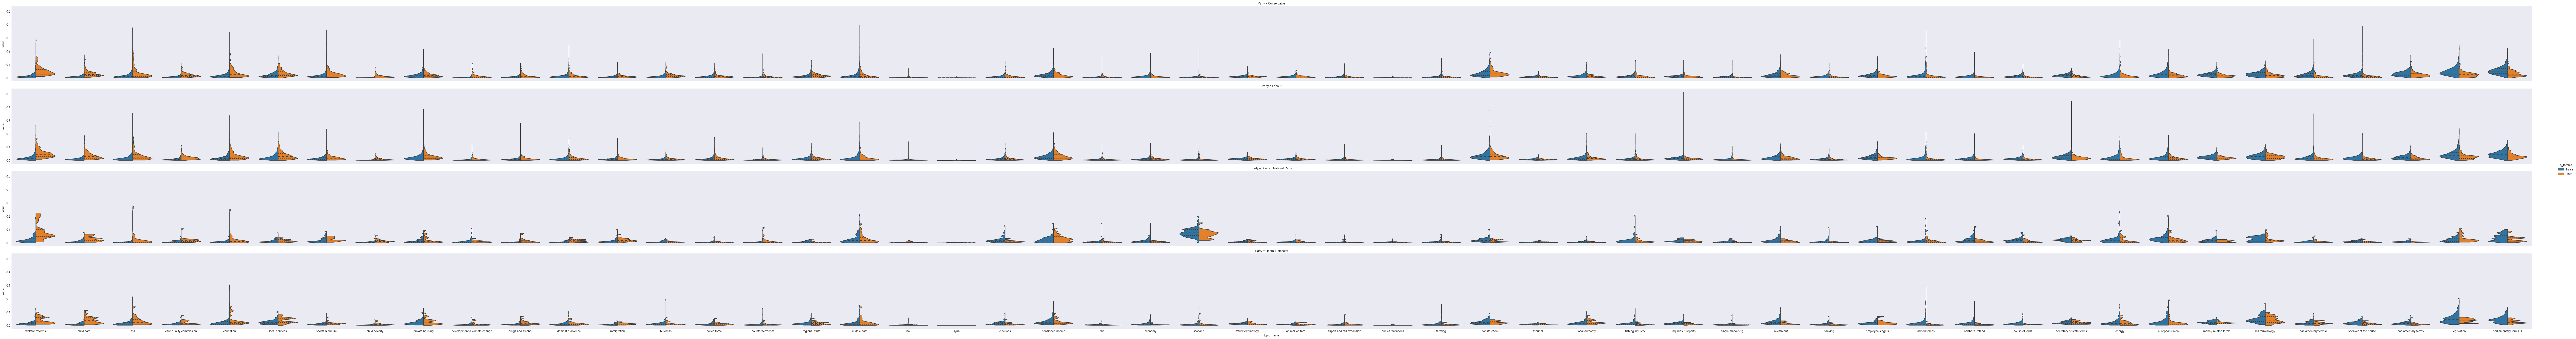

In [40]:
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline
sns.set_style("dark")
matplotlib.rcParams['figure.figsize'] = [12., 4.]
matplotlib.rcParams['figure.dpi'] = 100

factorplot = sns.factorplot(y="value", x="topic_name",
               hue="is_female", split=True,
               scale="width", gridsize=1000,
               kind="violin", row="Party", cut=0.,
               bw=0.2, inner="quartile", aspect=30,
               data=tidy_topics[tidy_topics.Party.isin(["Labour", "Conservative", "Liberal Democrat", "Scottish National Party"])
                                & tidy_topics.topic_name.isin(reverse_topic_dict.keys())
                               ].sort_values(["topic_id"])
    [["topic_id", "topic_name", "value", "full_name", "is_female", "Party"]])


In [140]:
from IPython.display import IFrame
IFrame(src="violin_plot.html", width=1500, height=1000)

In [32]:
from sklearn.preprocessing import StandardScaler

scaled = StandardScaler().fit_transform(normalised_mp_topics.fillna(0))

In [33]:
from sklearn.manifold import TSNE, MDS
import plotly.plotly as py
import plotly
tsne = TSNE(n_components=2, perplexity=20, n_iter=10000)
#tsne = MDS()
tsne_lda = tsne.fit_transform(normalised_mp_topics.fillna(0))

In [39]:
# Create Dataframe from tsne data
df = pd.DataFrame(tsne_lda).assign(mp=pd.to_numeric(list(normalised_mp_topics.index)))
df.columns = ["x", "y", "mp"]

# Join dataframe with mp info
df = df.join(mps[["is_female", "Party", "full_name"]], on="mp")

plotly.offline.iplot({
        "data": [
            {"x": list(df[df.Party==party].x),
            "y": list(df[df.Party==party].y),
            "text": list(df[df.Party==party].full_name),
             "name": party,
             "mode": "markers"
            }
            for party in df.Party.unique()
        ]
    })

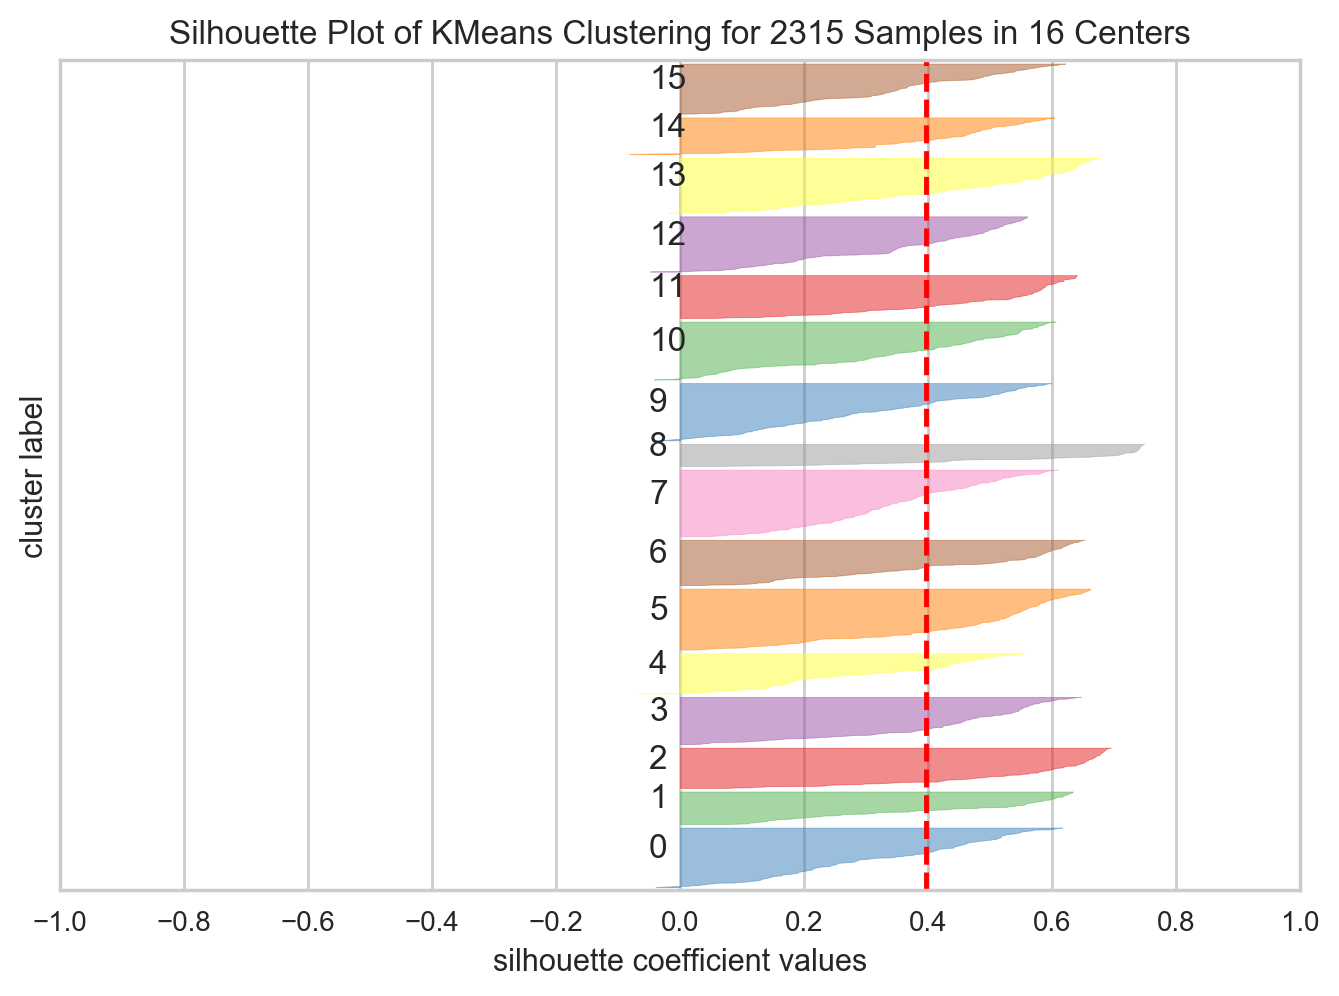

In [40]:
from sklearn.cluster import KMeans

from yellowbrick.cluster import SilhouetteVisualizer, KElbowVisualizer
model = SilhouetteVisualizer(KMeans(n_clusters=16))
#model = KElbowVisualizer(KMeans(), k=20)
model.fit(tsne_lda)
model.poof()

clusterer = KMeans(n_clusters=8)

cluster_labels = clusterer.fit_predict(tsne_lda)#normalised_mp_topics.fillna(0))

In [41]:
# Update the tooltip chart
hovered_symbol = ''
def hover_handler(self, content):
    global hovered_symbol
    symbol = content.get('data', '')
    if symbol != hovered_symbol:
        hovered_symbol = symbol["index"]
        bars.y=list(normalised_mp_topics.loc[df.iloc[hovered_symbol].mp].fillna(0))
        bar_figure.title = "{0} ({1})".format(df.iloc[hovered_symbol].full_name, df.iloc[hovered_symbol].Party)

def bar_hover_handler(self, content):
    print(content)
    hovered_topic = content.get("data", '')["x"]
    textbox.value = (speeches[(speeches["mp_id"] == df.iloc[hovered_symbol].mp) &
                           (speeches[reverse_topic_dict[hovered_topic]] > 0.4) &
                           (speeches["n_words"] > 0)].sample(n=1).body.iloc[0])

In [42]:
import bqplot as bq
import ipywidgets as ipyw
import numpy as np


bar_x_sc = bq.OrdinalScale()
bar_y_sc = bq.LinearScale(min=0, max=1)

bar_ax_x = bq.Axis(scale=bar_x_sc, tick_values=list(normalised_mp_topics.iloc[0].reset_index().topic_id))
bar_ax_y = bq.Axis(scale=bar_y_sc, orientation='vertical', side='left')

bars = bq.Bars(x=list(normalised_mp_topics.iloc[0].fillna(0).reset_index().topic_id),
       scales={'x':bar_x_sc,
              'y':bar_y_sc},
              tooltip=bq.Tooltip(fields=['x']))

bars.on_hover(bar_hover_handler)
bar_figure = bq.Figure(marks=[bars],
              axes=[bar_ax_x, bar_ax_y])

x_sc = bq.LinearScale()
y_sc = bq.LinearScale()
c_sc = bq.OrdinalColorScale(domain=list(np.unique(cluster_labels)), colors=bq.CATEGORY10[:len(np.unique(cluster_labels))])
#c_sc = bq.OrdinalColorScale(domain=df.party.unique().tolist(), colors=bq.CATEGORY10[:len(df.party.unique())])

ax_x = bq.Axis(scale=x_sc)
ax_y = bq.Axis( scale=y_sc, orientation='vertical')
tooltip = bq.Tooltip(fields=['x','y', 'name'] )
scatter = bq.Scatter(x=list(df.x), unique=list(df.mp),
             y=list(df.y),
                  names=list(df.full_name), display_names=False,
             scales={'x': x_sc, 'y': y_sc, 'color':c_sc},
                     color=list(cluster_labels), tooltip=tooltip)#color=list(df.party),

fig = bq.Figure(axes=[ax_x, ax_y], marks=[scatter])

textbox = ipyw.Textarea()
viz = ipyw.VBox([ipyw.Box([fig, bar_figure]), textbox])
scatter.on_hover(hover_handler)
viz


In [9]:
topics_time = speeches[list(range(100))].mul(speeches["n_words"], axis=0)
topics_time.columns = list(map(topic_dict, range(100)))

topics_time["date"] = speeches["date"]
#topics_time = topics_time.query('date > "2010-05-05"')
topics_time.set_index("date", inplace=True)

In [10]:
a = topics_time.reset_index().melt(id_vars="date")
a["is_filler"] = a["variable"].isin(["parliamentary terms","parliamentary terms+","parliamentary terms++", "bill terminology", "speaker of the house", "secretary of state terms", ])

In [11]:
topics_time = a.groupby(["date", "is_filler"]).sum().reset_index("is_filler")

In [12]:
topics_time = topics_time.pivot(columns="is_filler")

In [14]:
import cufflinks

In [15]:
topics_time.resample("A").sum().div(topics_time.resample("A").sum().sum(axis=1), axis=0).iplot(kind="bar", barmode="stack")

/home/durand/Stuff/Sources/anaconda3/envs/nlp/lib/python3.6/site-packages/cufflinks/plotlytools.py:156: FutureWarning:

pandas.tslib is deprecated and will be removed in a future version.
You can access Timestamp as pandas.Timestamp



In [47]:
clustered_mps = normalised_mp_topics.reset_index()
clustered_mps["cluster"] = cluster_labels
clustered_mps["gender"] = df["is_female"]

In [48]:
clustered_mps.gender = clustered_mps.gender.map(lambda x: "F" if x else "M")

In [49]:
clustered_mps["mp"] = clustered_mps["party"]
clustered_mps["party"] = df.Party

In [50]:
clustered_mps.query('party=="Conservative"').groupby("gender").median()[topics_to_graph].T.iplot(kind="bar")

In [51]:
clustered_mps.query('party=="Labour"').groupby("gender").median()[topics_to_graph].T.iplot(kind="bar")

In [55]:
clustered_mps.query('party=="Liberal Democrat"').groupby("gender").median()[topics_to_graph].T.iplot(kind="bar")

In [114]:
total_words = speeches.query("date > '1970-01-01'").join(mps[["is_female"]], on="mp_id").groupby(["date", "is_female"]).sum()[["n_words"]].reset_index().set_index("date")
total_words.is_female = total_words.is_female.map(lambda x: "F" if x else "M")
total_words = total_words.pivot(columns="is_female").resample("A").sum().fillna(0)
total_words.div(total_words.sum(axis=1), axis=0).iplot(kind="bar", barmode="stack")

In [115]:
n_words = speeches.query("date > '1970-01-01'")[["mp_id", "n_words", "date"]].set_index("date").groupby("mp_id").resample("A").sum()\
.reset_index("date").join(mps[["is_female", "full_name"]], how="left")#[["full_name", "is_female", "n_words"]]
n_words.is_female = n_words.is_female.map(lambda x: "F" if x else "M")


## Get number of BBC Question Time appearances

In [95]:
from wikitables import import_tables
qt_eps = import_tables("List_of_Question_Time_episodes")

qt = []
# Ignore the first few tables because they are irrelevant
for table in qt_eps[3:]:
    qt.extend(table.rows)
qt = pd.DataFrame(qt)

In [96]:
# Clean up the cells
qt = pd.DataFrame(dict(date = pd.to_datetime(qt.Airdate.map(lambda x: " ".join(x.value.split()[:3]))),
                 #location = qt.Location.map(lambda x: x.value),
                 panellists = qt.Panellists.map(lambda x: x.value)))
# Split panellists cell into individual rows per panellist
qt = pd.DataFrame(qt.panellists.str.split(",").tolist(), index=qt.date).stack().reset_index()[["date", 0]]
qt.rename(columns={0:"person"}, inplace=True)
# Strip whitespace from cell
qt.person = qt.person.map(lambda x: x.strip())

In [121]:
a = n_words.set_index("full_name")[["n_words", "is_female"]].join(qt.groupby("person").count().rename(columns={"date":"count"})).groupby("is_female").sum()

In [122]:
a.div(a.sum())

n_words     count
is_female                    
F          0.102611  0.208219
M          0.897389  0.791781